<h1>Objective of the Notebook</h1>
<p>The primary objective of this notebook is to develop a script that can accurately identify the category of an image from an e-commerce platform. This categorisation will enable the provision of more personalised product recommendations to customers.</p>
<h2>Methodology</h2>
<p>To achieve this objective, a two-stage approach is employed:</p>
<h3>Stage 1: Image Categorisation using Convolutional Neural Networks (CNNs)</h3>
<p>In the first stage, a CNN is utilised to classify the input image into its corresponding category. This is accomplished by training the CNN on a large dataset of images, each labelled with its respective category.</p>
<h3>Stage 2: Colour Detection and Analysis</h3>
<p>Once the category of the image has been determined, a colour detection algorithm is applied to identify the dominant colours present in the image. This information is then used to provide more accurate and personalised product recommendations.</p>
<h2>Models and Algorithms Used</h2>
<p>The following models and algorithms are employed in this script:</p>
<h3>1. Convolutional Neural Networks (CNNs) for Image Classification</h3>
<p>CNNs are a type of deep learning algorithm that are particularly effective for image classification tasks. They work by automatically and adaptively learning spatial hierarchies of features from images.</p>
<h3>2. K-Means Clustering</h3>
<p>K-Means clustering is an unsupervised machine learning algorithm that groups similar pixels in an image based on their colour values. This algorithm helps to identify the dominant colours in an image.</p>
<h3>3. CIE94 Colour Distance Formula</h3>
<p>The CIE94 colour distance formula is a widely used method for calculating the difference between two colours. This formula takes into account the human perception of colour and provides a more accurate measure of colour similarity.</p>
<h3>4. Face Landmark Detection</h3>
<p>Face landmark detection is a computer vision technique that identifies specific points on a face, such as the eyes, nose, and mouth. This algorithm is used to detect the face in an image and remove the facial region, allowing for more accurate colour detection and analysis.</p>

<h1>Comparison of CNN Models: From Scratch vs Transfer Learning</h1>
<p>It is worth noting that a different model was created using a method called transfer learning, leveraging the pre-trained VGG-16 model as the basis. This approach allowed us to tap into the knowledge the VGG-16 model has gained from being trained on a large dataset, potentially leading to improved performance.</p>
<h2>Evaluation Metrics</h2>
<p>After running the model fit, we achieved the following evaluation metrics:</p>
<table>
<tr>
<th>Model</th>
<th>Accuracy</th>
<th>Loss</th>
<th>Validation Accuracy</th>
<th>Validation Loss</th>
</tr>
<tr>
<td>Model from Scratch</td>
<td>0.9975</td>
<td>0.0119</td>
<td>0.8609</td>
<td>1.2897</td>
</tr>
<tr>
<td>VGG-16</td>
<td>1.0000</td>
<td>1.0995e-07</td>
<td>0.9139</td>
<td>1.7646</td>
</tr>
</table>
<p>These results indicate that the transfer learning model performed slightly better than the model created from scratch, at least in terms of validation accuracy.</p>
<h2>Practical Testing and Comparison</h2>
<p>However, when testing both models with multiple images, they threw exactly the same results. This suggests that, despite the slightly better validation accuracy of the transfer learning model, both models perform similarly in practice.</p>
<h2>Model Selection</h2>
<p>Given the comparable performance of both models, I decided to keep the one created from scratch. This decision was likely influenced by factors such as model interpretability, avoiding potential overfitting associated with transfer learning, or simply preferring a model that was built from the ground up using our specific dataset.</p>
<p>The results of the transfer learning model can be seen in the notebook called Final_project_with_ecommerce_images.ipynb</p>

In [4]:
import tensorflow as tf
import random
import numpy as np
import os
from dataclasses import dataclass
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import requests
import glob as glob

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

# Text formatting.
bold = "\033[1m"

# Fix seeds for reproducibility.
SEED_VALUE = 2000

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [11]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


# Directory Traversal and Label Creation Script
This script is designed to traverse a directory and its subdirectories, identify image files, and create labels based on the directory structure.

In [12]:
import os

# Define the directory path
root_dir = 'D:\\tmp\\Andrea\\train\\train'

# Initialize an empty dictionary to store labels
labels = {}
label_counter = 0

def traverse_directory(directory):
    global label_counter
    global labels

    # Get a list of subfolders and files
    contents = os.listdir(directory)

    image_found = False

    for item in contents:
        item_path = os.path.join(directory, item)

        # Check if item is a subfolder
        if os.path.isdir(item_path):
            # Recursively traverse subfolders
            traverse_directory(item_path)

        # Check if item is an image file
        if os.path.isfile(item_path) and item.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_found = True

    # Add label if an image was found
    if image_found:
        # Get relative directory path (excluding root_dir)
        rel_dir = os.path.relpath(directory, root_dir)

        labels[label_counter] = rel_dir
        label_counter += 1
#        print(f"Label {label_counter-1}: {rel_dir}")


# Start traversing from the root directory
traverse_directory(root_dir)

categories = []
# Save labels to a file (optional)
with open('labels.txt', 'w') as f:
    for key, value in labels.items():
        f.write(f"{key}: {value}\n")
        categories.append(value)

print("Labels created successfully.")
print(categories)

Labels created successfully.
['Camisas', 'Carteras', 'Chalecos y sacos', 'Cinturones', 'Lentes', 'Mochilas', 'Pantalones', 'Polos y playeras', 'ZapatoDeportivo']


In [13]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 9
    IMG_HEIGHT:   int = 628
    IMG_WIDTH:    int = 442
    NUM_CHANNELS: int = 3
    BATCH_SIZE:   int = 32
    DATA_ROOT:    str = 'D:\\tmp\\Andrea'

data_config = DatasetConfig()

# Set data paths.
train_path = os.path.join(data_config.DATA_ROOT, "train\\train")
valid_path = os.path.join(data_config.DATA_ROOT, "test")

In [14]:
print(train_path)
print(valid_path)

D:\tmp\Andrea\train\train
D:\tmp\Andrea\test


# Image Dataset Creation Script
This script is designed to create two image datasets, train_dataset and valid_dataset, from directories containing training and validation images, respectively.

In [15]:
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH)
batch_size = data_config.BATCH_SIZE

train_dataset = image_dataset_from_directory(directory=train_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

valid_dataset = image_dataset_from_directory(directory=valid_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

Found 431 files belonging to 9 classes.
Found 151 files belonging to 9 classes.


In [20]:
# Print the shape of the data and the aassociated labels.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 628, 442, 3)
labels batch shape: (32, 9)


In [21]:
# You can use the object attribute (class_names) to access the class names in the dataset.
valid_dataset.class_names

['Camisas',
 'Carteras',
 'Chalecos y sacos',
 'Cinturones',
 'Lentes',
 'Mochilas',
 'Pantalones',
 'Polos y playeras',
 'ZapatoDeportivo']

### 2.4 Display Sample Images from Dataset

### Primary Data Source
The primary source of images will be the ecommerce platform's existing product catalogue, which is expected to provide a comprehensive collection of product images.

### Secondary Data Sources
If necessary, additional images will be collected through:

<ul>
    <li>
Data augmentation techniques: New images will be created by modifying existing ones using techniques such as rotation, flipping, and colour adjustment. This will help increase the size of the dataset while maintaining diversity.
    </li>
    <li>
Web scraping methods: Relevant external websites will be scraped to collect product images, ensuring that the dataset remains diverse and comprehensive.
Data augmentation techniques: New images will be created by modifying existing ones using techniques such as rotation, flipping, and colour adjustment. This will help increase the size of the dataset while maintaining diversity.
    </li>
</ul>




# Visualising Sample Images from the Training Dataset

This script is designed to visualise a batch of sample images from the training dataset, along with their corresponding ground truth labels.

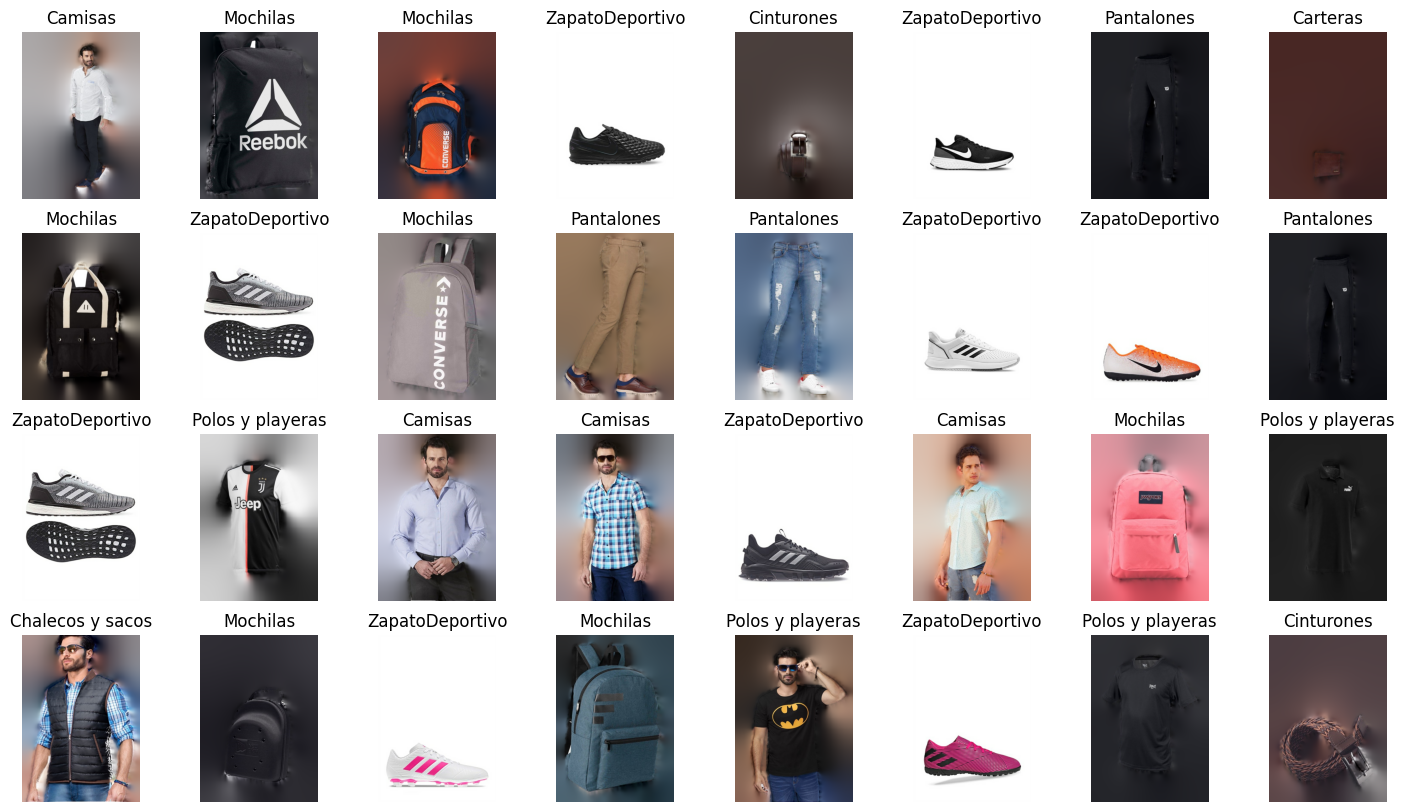

In [23]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # For the batch of images and the associated (one-hot encoded) labels,
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

plt.savefig('images/sample_images.png')


### 3.1 Define the Model

To ensure the efficacy of the image-based search engine, a sizable dataset of diverse product images is required for training and testing purposes.

This script defines a convolutional neural network (CNN) model using the Keras library. 

The model is designed for image classification tasks.
#### Model Architecture:
The model takes an input image of size 628x442x3 (RGB). </br>
The input image is rescaled to have pixel values between 0 and 1.</br>
The model consists of four convolutional blocks (Conv Block 1 to Conv Block 4), each comprising:</br>
<ul>
    <li>
Two convolutional layers (Conv2D) with 3x3 kernels, same padding, and ReLU activation.</br>        
    </li>
    <li>
A max-pooling layer (MaxPool2D) with a 2x2 window and stride 2.</br>        
    </li>
</ul>
After the convolutional blocks, the model flattens the output using a Flatten layer.</br>
The flattened output is then passed through two fully connected (dense) layers:</br>
The first dense layer has 512 units and ReLU activation.</br>
The second dense layer has num_classes units (9 in this case) and softmax activation for classification.</br>


In [87]:
# Define the model.
#def cnn_model(input_shape=(224, 224, 3), num_classes=10):
def cnn_model(input_shape=(628, 442, 3), num_classes=9):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [88]:
model = cnn_model(num_classes=data_config.NUM_CLASSES)

### 3.2 Set Training Configuration Parameters

In [89]:
@dataclass(frozen=True)
class TrainingConfig:
#    EPOCHS:             int   = 51
    EPOCHS:             int   = 20
    LEARNING_RATE:      float = 0.001

training_config = TrainingConfig()

### 3.3 Compile and Train the Model

In [90]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [91]:
# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [92]:
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
                             callbacks=[early_stopping])

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 304s 22s/step - accuracy: 0.2334 - loss: 2.2334 - val_accuracy: 0.3179 - val_loss: 1.7835
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 295s 21s/step - accuracy: 0.4902 - loss: 1.4708 - val_accuracy: 0.5629 - val_loss: 1.4652
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 301s 21s/step - accuracy: 0.6552 - loss: 1.1580 - val_accuracy: 0.6623 - val_loss: 1.0869
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 298s 21s/step - accuracy: 0.6641 - loss: 1.0106 - val_accuracy: 0.6623 - val_loss: 1.0648
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 301s 22s/step - accuracy: 0.7006 - loss: 0.9815 - val_accuracy: 0.7351 - val_loss: 0.8926
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 293s 21s/step - accuracy: 0.8044 - loss: 0.6780 - val_accuracy: 0.7417 - val_loss: 0.8391
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 295s 21s/step - accuracy: 0.8082 - loss: 0.5798 - val_accuracy: 0.7815 - val_loss: 0.8627
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 292s 21s/step - accuracy: 0.8746 - loss: 0.3697 - val_accuracy: 0.

<h1>Summary of Model Training Results</h1>
<p>The model was trained for 16 epochs, with a training set and a validation set. Below are the key results:</p>
<h2>Key Findings</h2>
<p>The training accuracy and validation accuracy both showed an increasing trend throughout the epochs. The training loss and validation loss both decreased throughout the epochs.</p>
<h3>General Trends</h3>
<p>The training accuracy increased steadily throughout the epochs, reaching a maximum of 99.75% in epoch 16. The training loss decreased steadily throughout the epochs, reaching a minimum of 0.0119 in epoch 16. The validation accuracy also increased, albeit with some fluctuations, reaching a maximum of 86.09% in epoch 16. The validation loss exhibited more erratic behaviour, with some increases and decreases throughout the epochs.</p>
<h3>Specific Observations</h3>
<p>The model's performance on the training set was consistently better than on the validation set.</p>
<p>In epoch 1, the training accuracy was 23.34%, indicating the model started with poor performance. From epoch 5 onwards, the training accuracy surpassed 70%, suggesting the model began learning meaningful patterns in the data. In epoch 15, the training accuracy reached an exceptionally high value of 99.27%, indicating the model had learned to classify the training data with great accuracy.</p>
<h2>Conclusion</h2>
<p>In general, the results suggest the model converged and achieved good performance on the training set. However, it is essential to note that the validation accuracy did not reach the same level as the training accuracy, which may indicate slight overfitting.</p>

# Plot the training result

In [95]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    name = "_".join([s.lower().replace(" ", "_") for s in metric_name]) + ".jpg"
    print(name)
    plt.savefig(name)
    plt.show(block=block_plot)
    plt.close()

training_accuracy_validation_accuracy.jpg


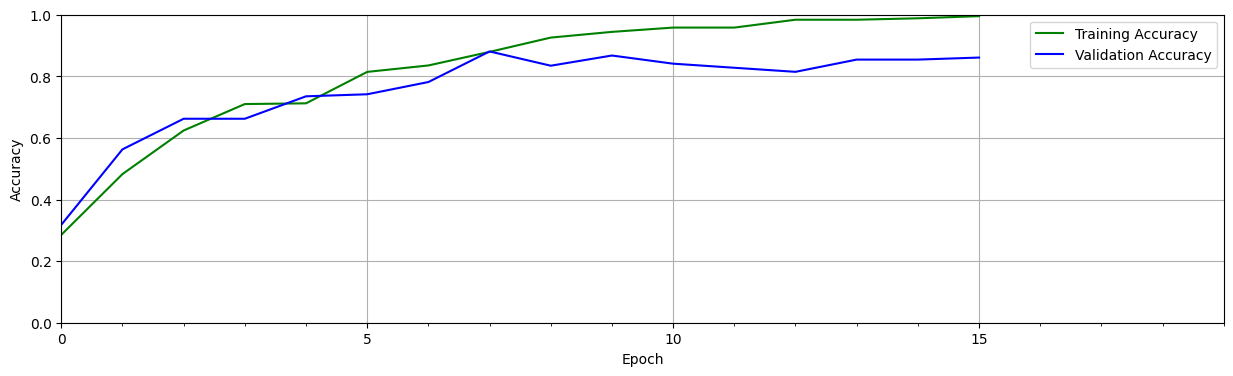

training_loss_validation_loss.jpg


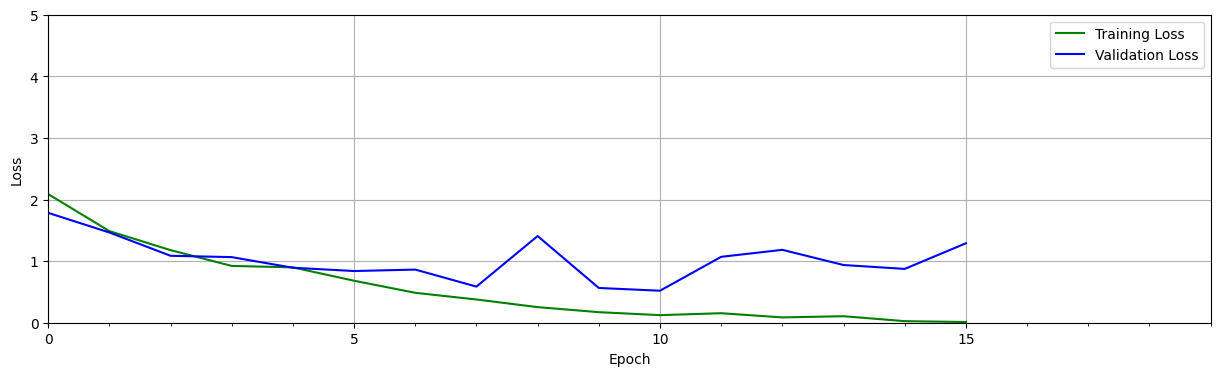

In [96]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [97]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 628, 442, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 628, 442, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 628, 442, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 628, 442, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 314, 221, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 314, 221, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 314, 221, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 157, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 157, 110, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 157, 110, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 78, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 78, 55, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 78, 55, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 39, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 269568)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │     138,019,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 417,588,605 (1.56 GB)

 Trainable params: 139,196,201 (530.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 278,392,404 (1.04 GB)

# Evaluate Model

Here, we will define a function that will call the `predict()` method on a portion of the validation dadaset, just so we can visualize the results on some of the images.

In [9]:
def evaluate_model(dataset, model):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        predictions = model.predict(data_batch)

        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())

            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})

            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')

            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)
    
    plt.savefig('images/eval.png')

    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction accuracy:  0.96


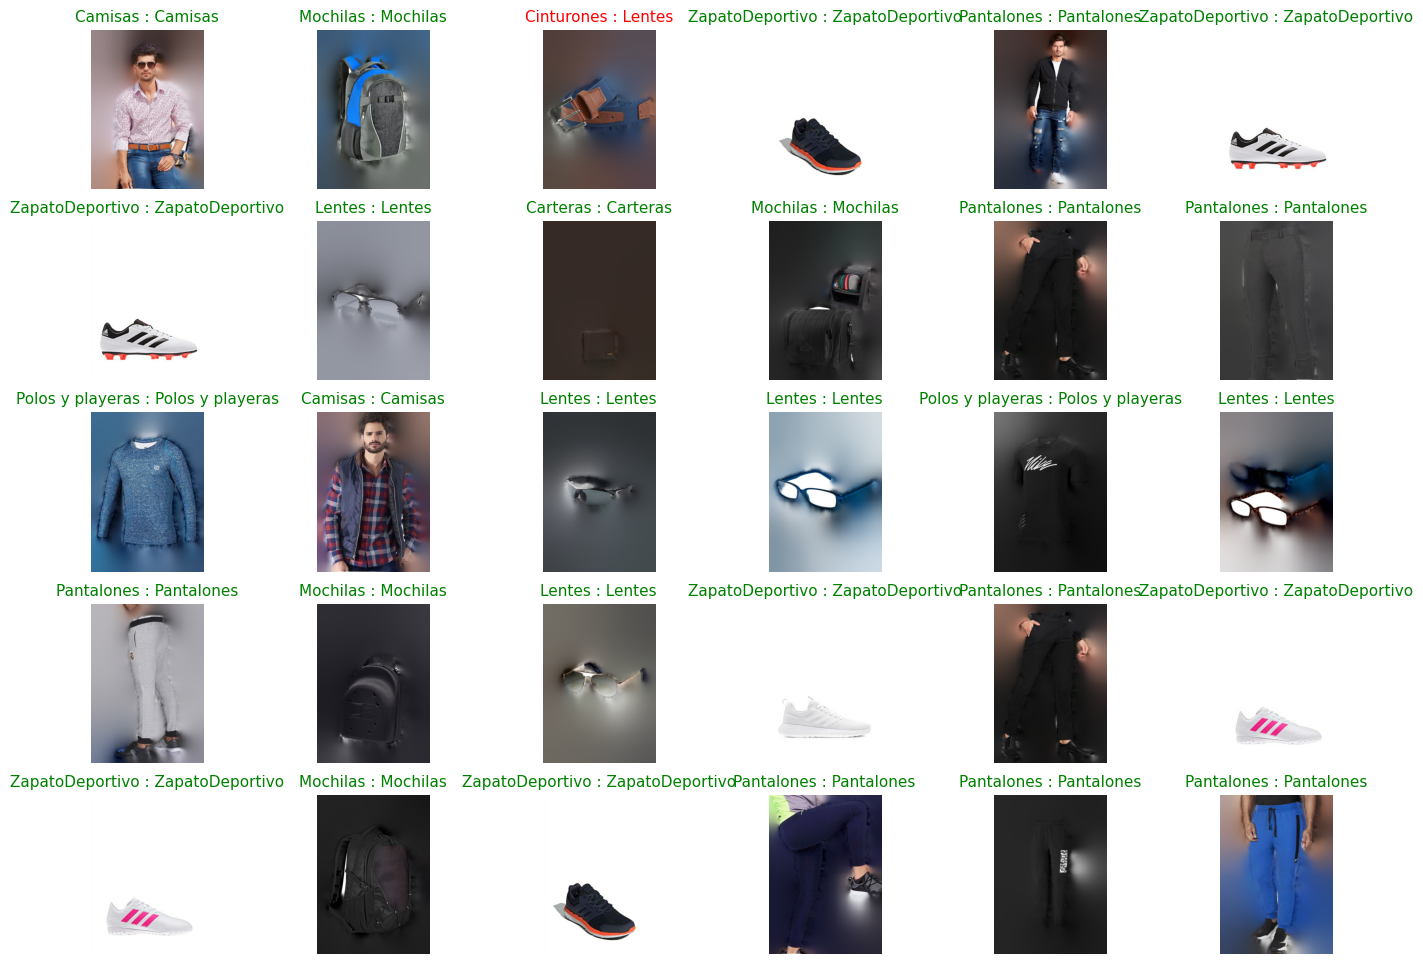

In [104]:
evaluate_model(valid_dataset, model)

#### Save the model

Saving the model in two formats h5 and keras

In [134]:
model.save('cnn_model.h5')
model.save('cnn_model.keras')


#### Loading the model

Now that we have the model saved, we can loaded for further use

In [6]:
# Load the saved model

loaded_model = keras.models.load_model('cnn_model.h5')

### Evaluate the model

We can see that the model reaches a 96% prediction accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction accuracy:  0.96


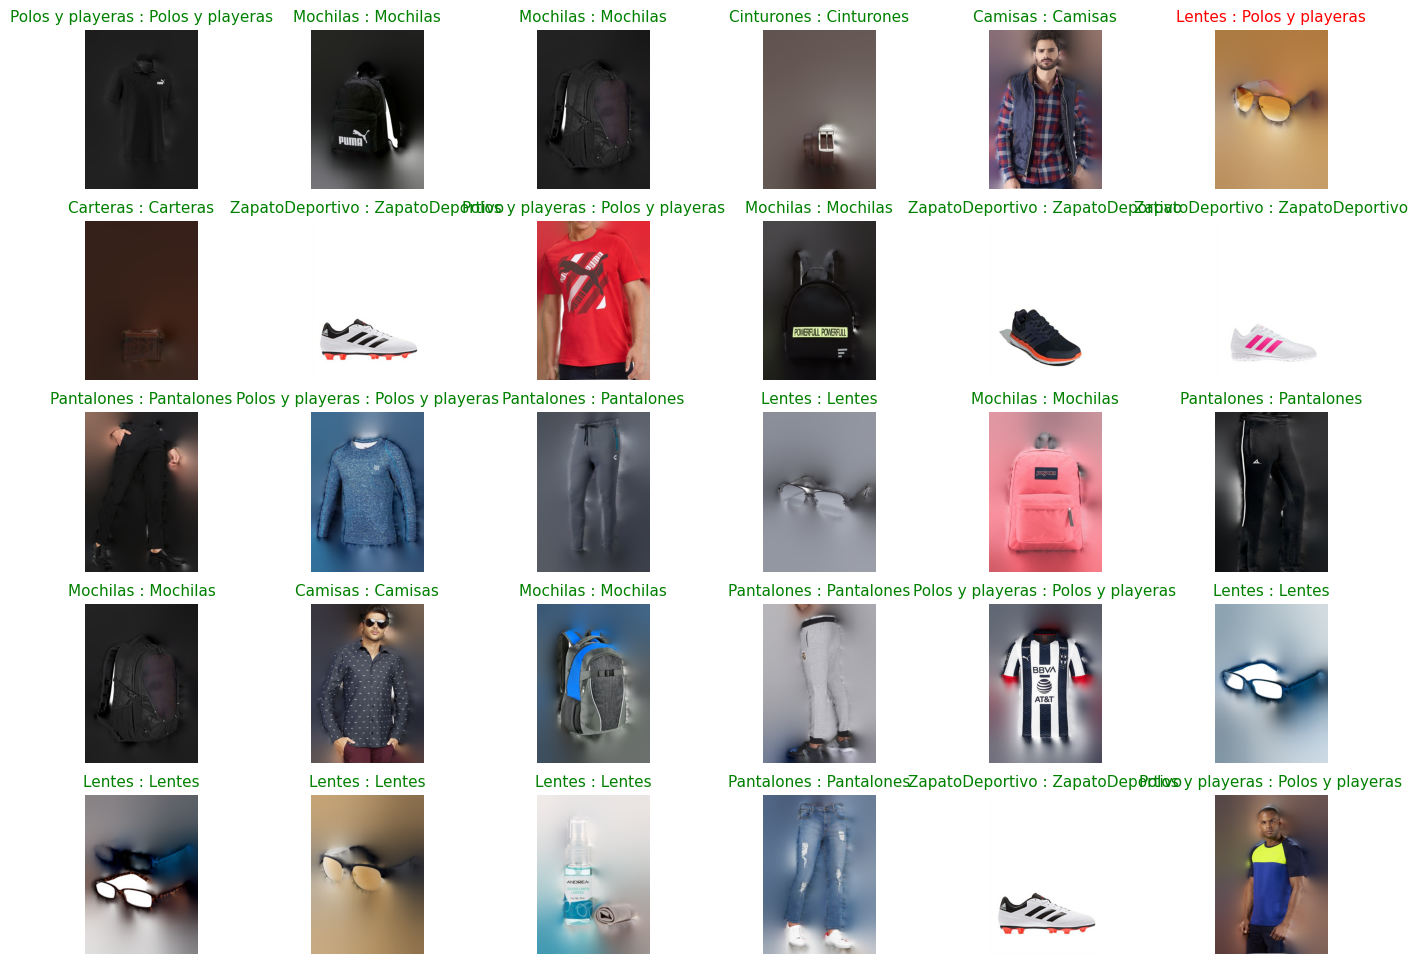

In [19]:
evaluate_model(valid_dataset, loaded_model)

### Testing the Model and Obtaining the Class
In this section, we utilise a test image to obtain the predicted class, which will subsequently be employed for further processing with the colour detection module. This step enables us to validate the model's performance on unseen data and leverage the predicted class for downstream applications.

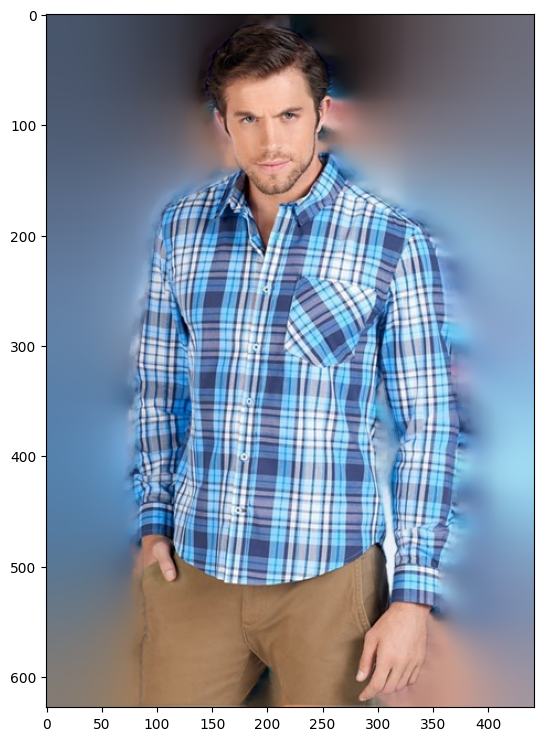

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Predicted Class: tf.Tensor(0, shape=(), dtype=int64)
Predicted Class: Camisas
valid_class: Camisas
Predicted Probabilities: [9.9995291e-01 2.1890138e-20 4.3626333e-05 2.4124624e-08 6.7923918e-14
 3.0325676e-08 1.4723926e-12 3.4340530e-06 7.6727969e-13]


In [25]:
# Load the new image
new_image = tf.io.read_file("test/Carteras/BOLSACAFE1451771UNI_masked.jpg")
new_image = tf.io.read_file('D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo\\ADIDASARGECYROJO26715430.jpg')
new_image = tf.io.read_file('test/Camisas/CAMISASAZUL14035580_masked.jpg')

new_image = tf.image.decode_jpeg(new_image, channels=3)

prt_img = tf.dtypes.cast(new_image, new_image.dtype)

# Plot the uploaded image
# Plot the uploaded image with transparent background
plt.imshow(prt_img)
plt.margins(0,0)
plt.show()
# Preprocess the image
new_image = tf.image.resize(new_image, (628, 442))

# Convert to tensor
new_image = tf.expand_dims(new_image, axis=0)

# Make predictions
predictions = loaded_model.predict(new_image)

# Print the predicted class
predicted_probabilities = predictions[0]
predicted_class = tf.argmax(predicted_probabilities)
#
print("Predicted Class:", predicted_class)
print("Predicted Class:", valid_dataset.class_names[predicted_class.numpy()])
valid_class = valid_dataset.class_names[predicted_class.numpy()]
print("valid_class:",valid_class)
print("Predicted Probabilities:", predicted_probabilities)

In [152]:
def check_model(dataset):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        for idx in range(num_rows*num_cols):
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            print(class_names[truth_idx[0][0]])
check_model(train_dataset)
#check_model(valid_dataset)

ZapatoDeportivo
Mochilas
Lentes
Mochilas
Cinturones
Pantalones
ZapatoDeportivo
Pantalones
ZapatoDeportivo
Lentes
Mochilas
Mochilas
ZapatoDeportivo
ZapatoDeportivo
Mochilas
ZapatoDeportivo
ZapatoDeportivo
Lentes
Cinturones
Polos y playeras
ZapatoDeportivo
ZapatoDeportivo
ZapatoDeportivo
Lentes
ZapatoDeportivo
Cinturones
ZapatoDeportivo
ZapatoDeportivo
Polos y playeras
ZapatoDeportivo


<Figure size 1700x1200 with 0 Axes>

<h1>Colour Detection and Comparison</h1>
<p>This section focuses on the colour detection and comparison stage of the process, which is crucial for identifying the relevant colours from an image. The category of the image has already been identified in a previous stage, and now the goal is to extract the dominant colours that define the image.</p>
<h2>Implemented Algorithms</h2>
<p>To achieve accurate colour detection and comparison, the following algorithms are implemented:</p>
<h3>1. K-Means Clustering</h3>
<p>K-Means clustering is an unsupervised machine learning algorithm that groups similar pixels in an image based on their colour values. This algorithm helps to identify the dominant colours in an image.</p>
<h3>2. CIE94 Colour Distance Formula</h3>
<p>The CIE94 colour distance formula is a widely used method for calculating the difference between two colours. This formula takes into account the human perception of colour and provides a more accurate measure of colour similarity.</p>
<h3>3. Face Landmark Detection</h3>
<p>Face landmark detection is a computer vision technique that identifies specific points on a face, such as the eyes, nose, and mouth. This algorithm is used to detect the face in an image and remove the facial region.</p>
<h2>Colour Detection and Comparison Process</h2>
<p>The colour detection and comparison process involves the following steps:</p>
<h3>1. Image Preprocessing</h3>
<p>The input image is preprocessed to enhance the colour features and remove any noise or artifacts.</p>
<h3>2. Colour Space Conversion</h3>
<p>The image is converted to a suitable colour space (RGB), to facilitate colour analysis.</p>
<h3>3. K-Means Clustering</h3>
<p>K-Means clustering is applied to the image to group similar pixels based on their colour values.</p>
<h3>4. Dominant Colour Extraction</h3>
<p>The dominant colours are extracted from the clustered pixels, and their colour values are calculated using the CIE94 colour distance formula.</p>
<h3>5. Colour Comparison</h3>
<p>The extracted colours are compared to a reference colour palette to identify the closest matching colours.</p>



<h1>Extracting Primary Colors from an Image</h1>
<p>This script defines a function <code>extract_primary_colors</code> that takes an image path and the number of primary colors to extract as input. The function returns a list of primary colors extracted from the image.</p>
<h2>Step 1: Face Detection and Landmark Prediction</h2>
<p>The function utilises the <code>dlib</code> library to detect faces in the image and predict facial landmarks.</p>
<pre><code>detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("path_to_shape_predictor.dat")</code></pre>
<h2>Step 2: Image Preprocessing</h2>
<p>The image is resized to a specified dimension and converted from BGR to RGB color space.</p>
<pre><code>img = cv2.resize(img_path, (628, 442))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)</code></pre>
<h2>Step 3: Face Masking</h2>
<p>The function creates a face mask by connecting facial landmarks and filling the mask with a transparent color.</p>
<pre><code>points = []
for n in range(1, 18):
x = landmarks.part(n).x
y = landmarks.part(n).y
points.append((x, y))
...
hull = cv2.convexHull(np.array(points))
mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [hull], 0, (0, 0, 0, 255), -1)</code></pre>
<h2>Step 4: Face Removal</h2>
<p>The face is removed from the image by setting the alpha channel of the face mask to 0.</p>
<pre><code>img[mask[:, :, 3] == 255, 3] = 0</code></pre>
<h2>Step 5: Color Clustering</h2>
<p>The image is reshaped into pixels, and pixels with low intensity are removed. The remaining pixels are then clustered into <code>n_colors</code> clusters using the K-Means algorithm.</p>
<pre><code>pixels = img.reshape((-1, 3))
pixels = pixels[np.any(pixels > 50, axis=1)]
kmeans = KMeans(n_clusters=n_colors)
kmeans.fit(pixels)
primary_colors = kmeans.cluster_centers_.astype(int)</code></pre>
<h2>Step 6: Color Sorting</h2>
<p>The primary colors are sorted in descending order based on the number of pixels in each cluster.</p>
<pre><code>color_counts = np.bincount(labels)
sorted_indices = np.argsort(color_counts)[::-1]
sorted_colors = primary_colors[sorted_indices]</code></pre>
<p>The function returns the sorted list of primary colors.</p>
<pre><code>return sorted_colors</code></pre>

In [107]:
import os
import cv2
import pandas as pd
import dlib
import numpy as np
from sklearn.cluster import KMeans


def extract_primary_colors(img_path, n_colors):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("C:\\projects\\visual\\Console\\MOPDlib\\MOPDlib\\Models\\shape_predictor_68_face_landmarks.dat")
#    img = cv2.imread(img_path)
    img = cv2.resize(img_path, (628, 442))

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = detector(img[:, :, :3])
    
    # Eliminar la cara de la imagen
    for face in faces:
        landmarks = predictor(img[:, :, :3], face)
    
        # Unir los puntos de referencia faciales para crear la máscara
        points = []
        for n in range(1, 18):  # puntos de la barbilla
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(18, 22):  # puntos de la ceja izquierda
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(22, 23):  # puntos que unen las cejas
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(22, 27):  # puntos de la ceja derecha
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(27, 18, -1):  # puntos de la oreja derecha a la izquierda
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))

        # Rellenar la máscara con un color transparente
        hull = cv2.convexHull(np.array(points))
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(mask, [hull], 0, (0, 0, 0, 255), -1)
    
        # Eliminar la cara de la imagen
        img[mask[:, :, 3] == 255, 3] = 0
    
    # Reshape image to pixels
    pixels = img.reshape((-1, 3))

    # Remove pixels with low intensity
    pixels = pixels[np.any(pixels > 50, axis=1)]

    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    primary_colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    # Contar la cantidad de píxeles para cada color
    color_counts = np.bincount(labels)

    # Ordenar los colores según la cantidad de píxeles
    sorted_indices = np.argsort(color_counts)[::-1]
    sorted_colors = primary_colors[sorted_indices]
    del detector
    del predictor

    return sorted_colors


<h1>Creating a Dataset of Dominant Colors</h1>
<p>This script creates a dataset of dominant colors extracted from a collection of images. The dataset is then saved as a CSV file.</p>
<h2>Step 1: Setting Up the Root Directory and Training Directory</h2>
<p>The script begins by defining the root directory and the training directory. The root directory is set to <code>'d:\tmp\Andrea\'</code>, and the training directory is set to a subdirectory within the root directory called <code>'train\train'</code>.</p>
<pre><code>root_dir = 'd:\tmp\Andrea\'
train_dir = os.path.join(root_dir, 'train\train')</code></pre>
<h2>Step 2: Creating a Dataset of Dominant Colors</h2>
<p>The script then creates a dataset of dominant colors by iterating through each subdirectory in the training directory. Each subdirectory represents a category, and within each category, there are multiple images.</p>
<pre><code>dataset = []
for clase in os.listdir(train_dir):
clase_dir = os.path.join(train_dir, clase)
if os.path.isdir(clase_dir):
for archivo in os.listdir(clase_dir):
imagen_path = os.path.join(clase_dir, archivo)
imagen = cv2.imread(imagen_path)
colores_dominantes = extract_primary_colors(imagen, n_colors)
dataset.append({
'image_name': archivo,
'category_name': clase,
'colors': [color.tolist() for color in colores_dominantes]
})</code></pre>
<p>For each image, the script extracts the dominant colors using the <code>extract_primary_colors</code> function, which takes the image and the number of colors to extract as input. The function returns a list of dominant colors, which are then added to the dataset along with the image name and category name.</p>
<h2>Step 3: Converting the Dataset to a Pandas DataFrame</h2>
<p>Once the dataset has been created, the script converts it to a Pandas DataFrame using the <code>pd.DataFrame</code> function.</p>
<pre><code>df = pd.DataFrame(dataset)</code></pre>
<h2>Step 4: Saving the DataFrame to a CSV File</h2>
<p>Finally, the script saves the DataFrame to a CSV file called <code>colores_dominantes_dataset.csv</code> using the <code>to_csv</code> function.</p>
<pre><code>df.to_csv('colores_dominantes_dataset.csv', index=False)</code></pre>


In [9]:


# Ruta raíz
root_dir = 'd:\\tmp\\Andrea\\'
n_colors = 4
# Ruta de entrenamiento
train_dir = os.path.join(root_dir, 'train\\train')

# Crear un conjunto de datos que incluya el nombre de la imagen y la clase
dataset = []
for clase in os.listdir(train_dir):
    clase_dir = os.path.join(train_dir, clase)
    if os.path.isdir(clase_dir):
        for archivo in os.listdir(clase_dir):
            imagen_path = os.path.join(clase_dir, archivo)
#            print(imagen_path)
            imagen = cv2.imread(imagen_path)
            colores_dominantes = extract_primary_colors(imagen, n_colors)
            dataset.append({
                'image_name': archivo,
                'category_name': clase,
#                'colors': colores_dominantes #colores_dominantes.tolist()  # Convertir a lista
                'colors': [color.tolist() for color in colores_dominantes]
            })

# Convertir el dataset a un pandas DataFrame
df = pd.DataFrame(dataset)

# Guardar el DataFrame como un archivo CSV
df.to_csv('colores_dominantes_dataset.csv', index=False)

# Implement CIE94 algorithm for colour comparison

<h1>Colour Distance Calculation Script</h1>
<p>This script defines a set of functions for calculating the colour distance between two colours using the CIE94 colour distance formula.</p>
<h2>CIE94 Colour Distance Formula</h2>
<p>The CIE94 colour distance formula is a widely used method for calculating the perceived colour difference between two colours. The formula takes into account the non-linear nature of human colour perception and provides a more accurate measure of colour difference than simple Euclidean distance calculations.</p>
<h2>Function 1: <code>cie94_distance</code></h2>
<p>The <code>cie94_distance</code> function calculates the CIE94 colour distance between two colours. The function takes two RGB colour values as input and returns the calculated colour distance.</p>
<pre><code>def cie94_distance(color1, color2):
# Convertir colores a CIE Lab
lab1 = rgb_to_lab(color1)
lab2 = rgb_to_lab(color2)
# Calcular la distancia CIE94
delta_e = math.sqrt(
    (lab1[0] - lab2[0]) ** 2 +
    (lab1[1] - lab2[1]) ** 2 +
    (lab1[2] - lab2[2]) ** 2
)

return delta_e</code></pre>
<h2>Function 2: <code>rgb_to_lab</code></h2>
<p>The <code>rgb_to_lab</code> function converts an RGB colour value to a CIE Lab colour value. The function takes an RGB colour value as input and returns the corresponding CIE Lab colour value.</p>
<pre><code>def rgb_to_lab(rgb):
# Convertir RGB a XYZ
xyz = [
0.412453 * rgb[0] + 0.357580 * rgb[1] + 0.180423 * rgb[2],
0.212671 * rgb[0] + 0.715160 * rgb[1] + 0.072169 * rgb[2],
0.019334 * rgb[0] + 0.119193 * rgb[1] + 0.950227 * rgb[2]
]
# Convertir XYZ a Lab
lab = [
    116 * lab_f(xyz[1]) - 16,
    500 * (lab_f(xyz[0]) - lab_f(xyz[1])),
    200 * (lab_f(xyz[1]) - lab_f(xyz[2]))
]

return lab</code></pre>
<h2>Function 3: <code>lab_f</code></h2>
<p>The <code>lab_f</code> function is a helper function used in the <code>rgb_to_lab</code> function to calculate the Lab colour values. The function takes a single input value and returns the calculated Lab value.</p>
<pre><code>def lab_f(t):
if t > 0.008856:
return t ** (1/3)
else:
return 7.787 * t + 16/116</code></pre>

In [21]:
import pandas as pd
import numpy as np
import math

def cie94_distance(color1, color2):
    # Convertir colores a CIE Lab
    lab1 = rgb_to_lab(color1)
    lab2 = rgb_to_lab(color2)

    # Calcular la distancia CIE94
    delta_e = math.sqrt(
        (lab1[0] - lab2[0]) ** 2 +
        (lab1[1] - lab2[1]) ** 2 +
        (lab1[2] - lab2[2]) ** 2
    )

    return delta_e


def rgb_to_lab(rgb):
    # Convertir RGB a XYZ
    xyz = [
        0.412453 * rgb[0] + 0.357580 * rgb[1] + 0.180423 * rgb[2],
        0.212671 * rgb[0] + 0.715160 * rgb[1] + 0.072169 * rgb[2],
        0.019334 * rgb[0] + 0.119193 * rgb[1] + 0.950227 * rgb[2]
    ]

    # Convertir XYZ a Lab
    lab = [
        116 * lab_f(xyz[1]) - 16,
        500 * (lab_f(xyz[0]) - lab_f(xyz[1])),
        200 * (lab_f(xyz[1]) - lab_f(xyz[2]))
    ]

    return lab


def lab_f(t):
    if t > 0.008856:
        return t ** (1/3)
    else:
        return 7.787 * t + 16/116


# Obtain dominant colours of a test image

<p>This script calculates the similarity between the dominant colours of a test image and a dataset of images. The script uses the CIE94 colour distance formula to calculate the similarity between colours.</p>
<h2>Step 1: Loading the Test Image</h2>
<p>The script begins by loading a test image using the <code>cv2.imread</code> function.</p>
<pre><code>imagen_prueba = cv2.imread('test/Camisas/CAMISASAZUL14035580_masked.jpg')</code></pre>
<h2>Step 2: Extracting Dominant Colours from the Test Image</h2>
<p>The script then extracts the dominant colours from the test image using the <code>extract_primary_colors</code> function.</p>
<pre><code>colores_dominantes_prueba = extract_primary_colors(imagen_prueba, 4)</code></pre>
<h2>Step 3: Loading the Colour Dataset</h2>
<p>The script loads a CSV file containing a dataset of images and their corresponding dominant colours.</p>
<pre><code>df = pd.read_csv('colores_dominantes_dataset.csv')</code></pre>
<h2>Step 4: Calculating Colour Similarity</h2>
<p>The script then calculates the similarity between the dominant colours of the test image and each image in the dataset. The similarity is calculated using the CIE94 colour distance formula.</p>
<pre><code>similitudes = []
for index, row in df.iterrows():
colores = row['colors']
colores = eval(colores)
appended = False
for color_prueba in colores_dominantes_prueba:
for color in colores:
color = np.array(color)
similitud = cie94_distance(color, color_prueba)
        if similitud <= 15 and appended == False: #
            similitudes.append((index, row['image_name'], row['category_name'], similitud, color, color_prueba))
            appended = True
        else:
            continue</code></pre>
<h2>Step 5: Sorting and Printing Colour Similarities</h2>
<p>The script sorts the colour similarities in ascending order and prints the results.</p>
<pre><code>similitudes_ordenadas = sorted(similitudes, key=lambda x: x[3], reverse=False)
Imprimir todas las similitudes
for index, image_name, category_name, similitud, color, color_prueba in similitudes_ordenadas:
print(f"Imagen: {image_name} - Clase: {category_name} - Similitud: {similitud:.2f} - Color: {color} - Color_prueba: {color_prueba}")</code></pre>

In [111]:

# Cargar la imagen de prueba

#imagen_prueba = cv2.imread('D:\\tmp\\Andrea\\train\\train\\Chalecos y sacos\\PUMAESSENTIALSPADDEDVESTNEGRO14848780_masked.jpg')
imagen_prueba = cv2.imread('D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg')
imagen_prueba = cv2.imread('test/Camisas/CAMISASAZUL14035580_masked.jpg')
# Detectar los colores dominantes de la imagen de prueba
colores_dominantes_prueba = extract_primary_colors(imagen_prueba, 4)
# Cargar el archivo CSV
df = pd.read_csv('colores_dominantes_dataset.csv')


similitudes = []
    
for index, row in df.iterrows():
    colores = row['colors']
    colores = eval(colores)
    appended = False
    for color_prueba in colores_dominantes_prueba:
        for color in colores:
            color = np.array(color)
            similitud = cie94_distance(color, color_prueba)

            if similitud <= 15 and appended == False: #
                similitudes.append((index, row['image_name'], row['category_name'], similitud, color, color_prueba))
                appended = True
            else:
                continue

similitudes_ordenadas = sorted(similitudes, key=lambda x: x[3], reverse=False)

# Imprimir todas las similitudes
for index, image_name, category_name, similitud, color, color_prueba in similitudes_ordenadas:
    print(f"Imagen: {image_name} - Clase: {category_name} - Similitud: {similitud:.2f} - Color: {color} - Color_prueba: {color_prueba}")

Imagen: CAMISASAZUL14035581_masked.jpg - Clase: Camisas - Similitud: 0.00 - Color: [106 136 173] - Color_prueba: [106 136 173]
Imagen: CHALECOSNEGRO14318720_masked.jpg - Clase: Chalecos y sacos - Similitud: 7.82 - Color: [108 139 173] - Color_prueba: [106 136 173]
Imagen: CHALECOSNEGRO14318722_masked.jpg - Clase: Chalecos y sacos - Similitud: 7.82 - Color: [108 139 173] - Color_prueba: [106 136 173]
Imagen: CAMISASBLANCO14318581_masked.jpg - Clase: Camisas - Similitud: 9.03 - Color: [159 127 110] - Color_prueba: [165 130 110]
Imagen: BOLSAAZULUNI14246900_masked.jpg - Clase: Mochilas - Similitud: 10.70 - Color: [ 73  82 103] - Color_prueba: [ 77  83 101]
Imagen: CAMISASVINO14562710_masked.jpg - Clase: Camisas - Similitud: 10.79 - Color: [168 129 113] - Color_prueba: [165 130 110]
Imagen: DEPORTIVOBLANCO27092840.jpg - Clase: ZapatoDeportivo - Similitud: 13.32 - Color: [117 140 178] - Color_prueba: [106 136 173]
Imagen: CAMISASAZUL14035582_masked.jpg - Clase: Camisas - Similitud: 13.38 - 

In [4]:
df.head()

image_name category_name  \
0  BOLSANEGROUNI13812902_masked.jpg       Camisas   
1    CAMISASAZUL14035581_masked.jpg       Camisas   
2    CAMISASAZUL14035582_masked.jpg       Camisas   
3    CAMISASAZUL14035724_masked.jpg       Camisas   
4    CAMISASAZUL14036713_masked.jpg       Camisas   

                                              colors  
0  [[175, 164, 160], [217, 215, 215], [134, 112, ...  
1  [[106, 136, 173], [162, 196, 223], [77, 83, 10...  
2  [[116, 140, 171], [149, 122, 108], [174, 199, ...  
3  [[182, 202, 239], [174, 165, 180], [140, 122, ...  
4  [[112, 114, 137], [134, 101, 92], [67, 58, 62]...

<h1>Colour Similarity Image Plotting Script</h1>
<p>This script plots the test image and its top 5 colour similar images using the Matplotlib library.</p>
<h2>Step 1: Loading the Test Image</h2>
<p>The script begins by loading the test image using the <code>mpimg.imread</code> function.</p>
<pre><code>imagen_prueba_path = 'test/Camisas/CAMISASAZUL14035580_masked.jpg'
img_prueba = mpimg.imread(imagen_prueba_path)</code></pre>
<h2>Step 2: Creating the Figure and Subplots</h2>
<p>The script then creates a figure with a specified size and creates subplots to display the test image and its similar images.</p>
<pre><code>plt.figure(figsize=(30, 5))
plt.subplot(1, 6, 1)
plt.imshow(img_prueba)
plt.title("Imagen de prueba")
plt.axis('off') # This will remove the axis</code></pre>
<h2>Step 3: Plotting Similar Images</h2>
<p>The script then plots the top 5 similar images by iterating through the <code>similitudes_ordenadas</code> list and loading each image using the <code>mpimg.imread</code> function.</p>
<pre><code>for i, (index, image_name, category_name, similitud, color, color_prueba) in enumerate(similitudes_ordenadas[:5]):
image_path = os.path.join(train_dir, category_name, image_name)
img = mpimg.imread(image_path)
plt.subplot(1, 6, i+2) # Start from 2 to account for the first image
plt.imshow(img)
plt.title(f"Imagen: \n{image_name} -\n Clase: {category_name} -\n Similitud: {similitud:.2f}")
plt.axis('off') # This will remove the axis</code></pre>
<h2>Step 4: Saving and Displaying the Plot</h2>
<p>Finally, the script saves the plot to a file called <code>test_colour.jpg</code> and displays the plot using the <code>plt.show</code> function.</p>
<pre><code>plt.tight_layout()
plt.savefig('images/test_colour.jpg')
plt.show()</code></pre>

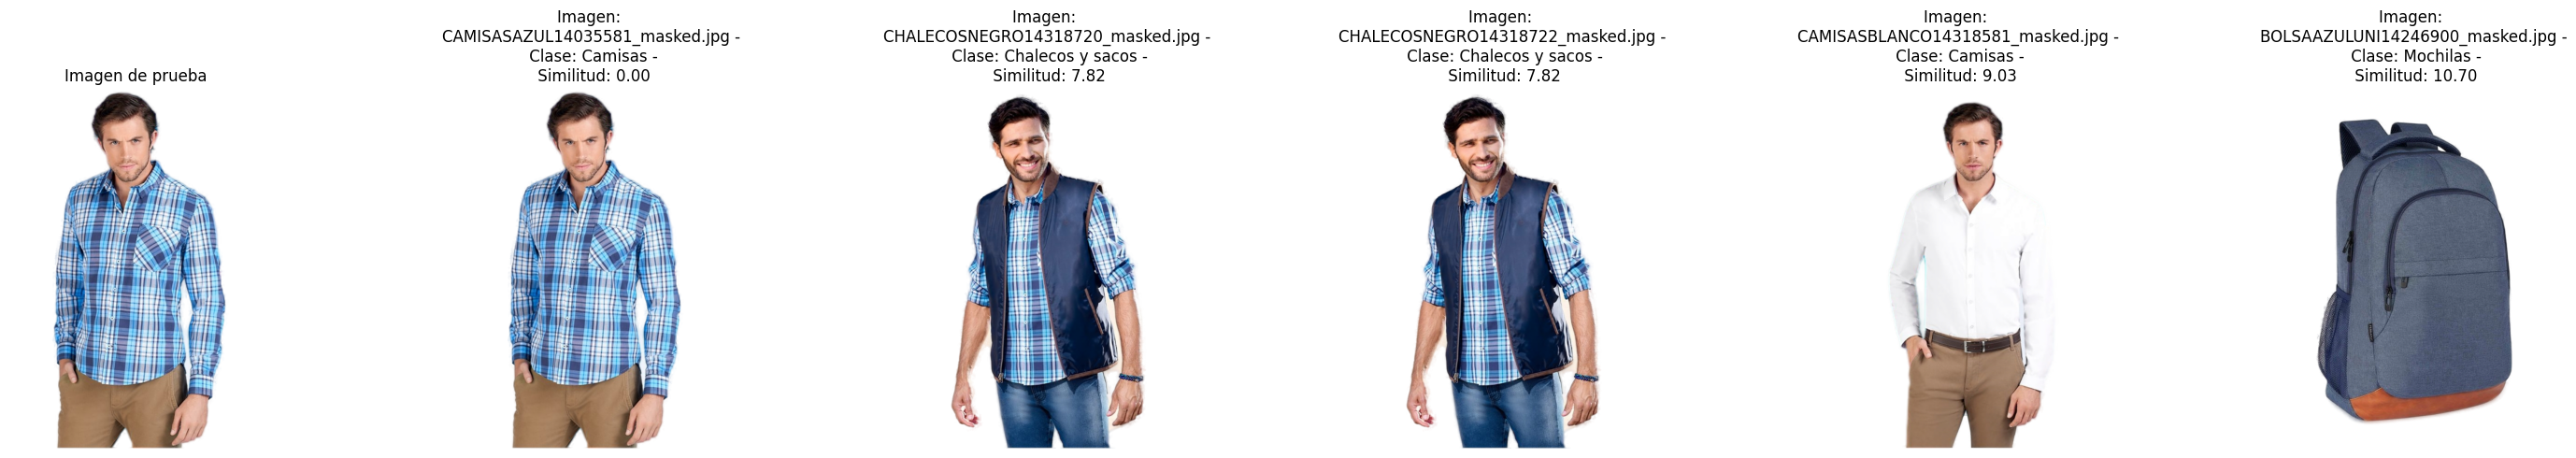

In [112]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plotear la imagen de prueba
imagen_prueba_path = 'D:\\tmp\\Andrea\\train\\train\\Chalecos y sacos\\PUMAESSENTIALSPADDEDVESTNEGRO14848780_masked.jpg'
imagen_prueba_path = 'D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg'
imagen_prueba_path = 'test/Camisas/CAMISASAZUL14035580_masked.jpg'

root_dir = 'd:\\tmp\\Andrea\\'
n_colors = 4
# Ruta de entrenamiento
train_dir = os.path.join(root_dir, 'train\\train')


img_prueba = mpimg.imread(imagen_prueba_path)
# Plotear la imagen de prueba y las imágenes similares
plt.figure(figsize=(30, 5))
plt.subplot(1, 6, 1)
plt.imshow(img_prueba)
plt.title("Imagen de prueba")
plt.axis('off')  # This will remove the axis

for i, (index, image_name, category_name, similitud, color, color_prueba) in enumerate(similitudes_ordenadas[:5]):
    image_path = os.path.join(train_dir, category_name, image_name)
    img = mpimg.imread(image_path)
    plt.subplot(1, 6, i+2)  # Start from 2 to account for the first image
    plt.imshow(img)
    plt.title(f"Imagen: \n{image_name} -\n Clase: {category_name} -\n Similitud: {similitud:.2f}")
    plt.axis('off')  # This will remove the axis

plt.tight_layout()
plt.savefig('images/test_colour.jpg')

plt.show()

# Deployment with class detected from image classification

<h1>Colour Similarity Image Plotting Script</h1>
=====================================================


<p>This script plots the test image and its top 5 colour similar images using the Matplotlib library.</p>


<h2>Step 1: Loading the Test Image</h2>

<p>The script begins by loading the test image using the <code>mpimg.imread</code> function.</p>

<pre><code>imagen_prueba_path = 'test/Camisas/CAMISASAZUL14035580_masked.jpg'
img_prueba = mpimg.imread(imagen_prueba_path)</code></pre>


<h2>Step 2: Creating the Figure and Subplots</h2>

<p>The script then creates a figure with a specified size and creates subplots to display the test image and its similar images.</p>

<pre><code>plt.figure(figsize=(30, 5))
plt.subplot(1, 6, 1)
plt.imshow(img_prueba)
plt.title("Imagen de prueba")
plt.axis('off')  # This will remove the axis</code></pre>


<h2>Step 3: Plotting Similar Images</h2>

<p>The script then plots the top 5 similar images by iterating through the <code>similitudes_ordenadas</code> list and loading each image using the <code>mpimg.imread</code> function.</p>

<pre><code>for i, (index, image_name, category_name, similitud, color, color_prueba) in enumerate(similitudes_ordenadas[:5]):
    image_path = os.path.join(train_dir, category_name, image_name)
    img = mpimg.imread(image_path)
    plt.subplot(1, 6, i+2)  # Start from 2 to account for the first image
    plt.imshow(img)
    plt.title(f"Imagen: \n{image_name} -\n Clase: {category_name} -\n Similitud: {similitud:.2f}")
    plt.axis('off')  # This will remove the axis</code></pre>


<h2>Step 4: Saving and Displaying the Plot</h2>

<p>Finally, the script saves the plot to a file called <code>test_colour.jpg</code> and displays the plot using the <code>plt.show</code> function.</p>

<pre><code>plt.tight_layout()
plt.savefig('images/test_colour.jpg')
plt.show()</code></pre>

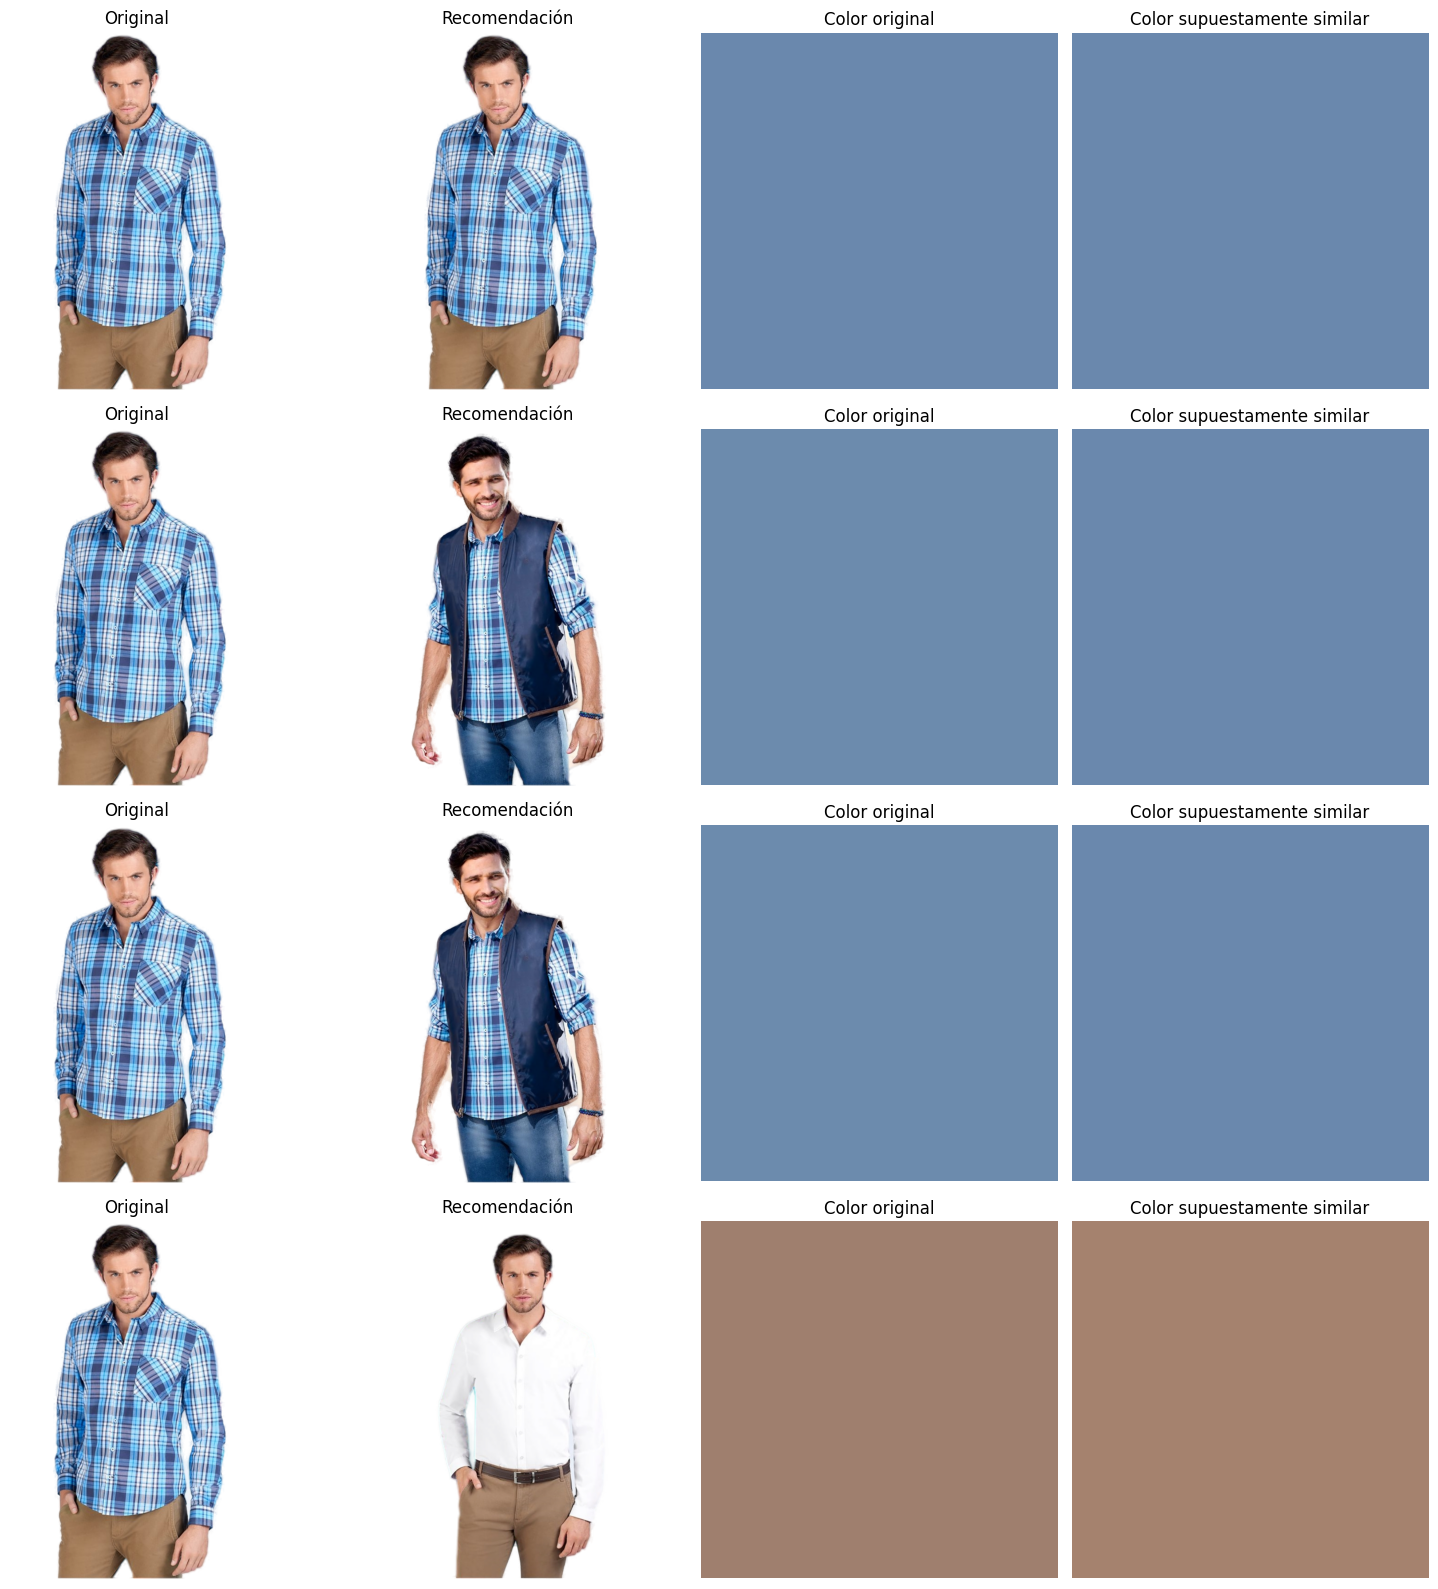

In [113]:
def display_image_colors(orig_image, image_path, color, color_prueba, axs):
    axs[0].imshow(mpimg.imread(orig_image))
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(mpimg.imread(image_path))
    axs[1].set_title("Recomendación")
    axs[1].axis('off')

    axs[2].imshow(np.full((80, 80, 3), color, dtype=np.uint8))
    axs[2].set_title("Color original")
    axs[2].axis('off')

    axs[3].imshow(np.full((80, 80, 3), color_prueba, dtype=np.uint8))
    axs[3].set_title("Color supuestamente similar")
    axs[3].axis('off')

# Plotear las imágenes similares
count = 0
num_filas = 4
fig, axs = plt.subplots(num_filas, 4, figsize=(15, 4 * num_filas))
for index, image_name, category_name, similitud, color, color_prueba in similitudes_ordenadas:
    image_path = os.path.join(train_dir, category_name, image_name)
    display_image_colors(imagen_prueba_path, image_path, color, color_prueba, axs[count])
    count += 1
    if count == num_filas:
        break
plt.tight_layout()
plt.savefig('images/recomendaciones.jpg')
plt.show()

<h1>Face Removal Script</h1>
<p>This script removes the face from an image using the Dlib library and OpenCV. The script uses a pre-trained model to detect the face and then removes it by creating a mask.</p>
<h2>Step 1: Loading the Pre-Trained Model</h2>
<p>The script begins by loading the pre-trained model for face detection.</p>
<pre><code>detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:\projects\visual\Console\MOPDlib\MOPDlib\Models\shape_predictor_68_face_landmarks.dat")</code></pre>
<h2>Step 2: Loading the Image</h2>
<p>The script then loads the image from which the face will be removed.</p>
<pre><code>original = 'test/Camisas/CAMISASAZUL14035580_masked.jpg'
img = cv2.imread(original, cv2.IMREAD_UNCHANGED)</code></pre>
<h2>Step 3: Detecting the Face</h2>
<p>The script detects the face in the image using the pre-trained model.</p>
<pre><code>faces = detector(img[:, :, :3])</code></pre>
<h2>Step 4: Creating the Face Mask</h2>
<p>The script creates a mask for the face by connecting the facial landmarks.</p>
<pre><code>for face in faces:
landmarks = predictor(img[:, :, :3], face)
# Unir los puntos de referencia faciales para crear la máscara
points = []
for n in range(1, 18):  # puntos de la barbilla
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    points.append((x, y))
for n in range(18, 22):  # puntos de la ceja izquierda
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    points.append((x, y))
for n in range(22, 23):  # puntos que unen las cejas
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    points.append((x, y))
for n in range(22, 27):  # puntos de la ceja derecha
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    points.append((x, y))
for n in range(27, 18, -1):  # puntos de la oreja derecha a la izquierda
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    points.append((x, y))

### Fill the mask with a transparent colour
hull = cv2.convexHull(np.array(points))
mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [hull], 0, (0, 0, 0, 255), -1)

### Remove the face from the image
img[mask[:, :, 3] == 255, 3] = 0
break</code></pre>
<h2>Step 5: Saving the Faceless Image</h2>
<p>The script saves the faceless image with transparency.</p>
<pre><code>from PIL import Image
Save the faceless image with transparency
faceless = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))
faceless.save("img_sin_cara2.png")</code></pre>
<h2>Step 6: Displaying the Original and Faceless Images</h2>
<p>The script displays the original and faceless images using Matplotlib.</p>
<pre><code>fig, axs = plt.subplots(1, 2, figsize=(12, 6))
Display the original image on the first subplot
orig = Image.open(original)
axs[0].imshow(orig)
axs[0].set_title('Original Image')
Display the image with the face removed on the second subplot
faceless = Image.open("img_sin_cara2.png")
axs[1].imshow(faceless)
axs[1].set_title('Face Removed Image')
Remove the axis ticks and frames
for ax in axs:
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
plt.savefig('images/faceless.png')
Show the plot
plt.show()</code></pre>

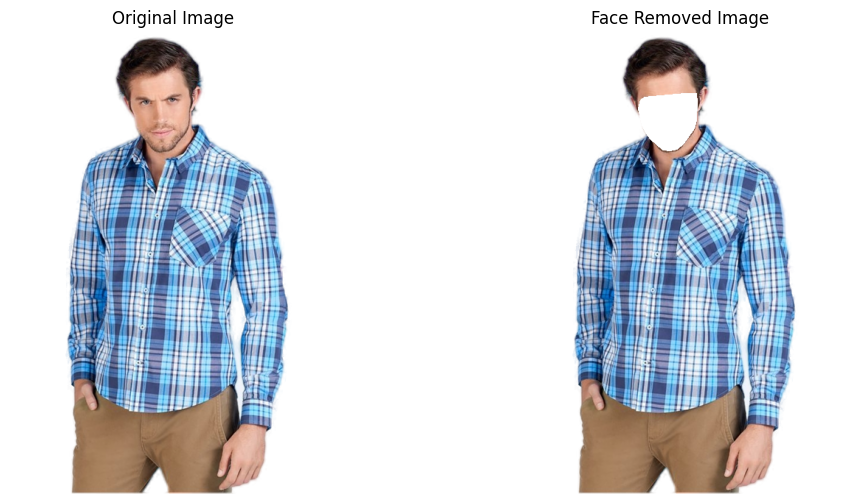

In [114]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:\\projects\\visual\\Console\\MOPDlib\\MOPDlib\\Models\\shape_predictor_68_face_landmarks.dat")

original = "D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg"
original = 'test/Camisas/CAMISASAZUL14035580_masked.jpg'

# Cargar la imagen
img = cv2.imread(original, cv2.IMREAD_UNCHANGED)

# Detectar la cara
faces = detector(img[:, :, :3])

# Eliminar la cara de la imagen
for face in faces:
    landmarks = predictor(img[:, :, :3], face)

    # Unir los puntos de referencia faciales para crear la máscara
    points = []
    for n in range(1, 18):  # puntos de la barbilla
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(18, 22):  # puntos de la ceja izquierda
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(22, 23):  # puntos que unen las cejas
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(22, 27):  # puntos de la ceja derecha
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(27, 18, -1):  # puntos de la oreja derecha a la izquierda
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))

    # Rellenar la máscara con un color transparente
    hull = cv2.convexHull(np.array(points))
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [hull], 0, (0, 0, 0, 255), -1)

    # Eliminar la cara de la imagen
    img[mask[:, :, 3] == 255, 3] = 0
    break

# Liberar la memoria
del detector
del predictor

# Guardar la imagen sin la cara
#cv2.imwrite("img_sin_cara2.png", img)
from PIL import Image

# Save the faceless image with transparency
faceless = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))
faceless.save("img_sin_cara2.png")


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image on the first subplot
orig = Image.open(original)
axs[0].imshow(orig)
axs[0].set_title('Original Image')

# Display the image with the face removed on the second subplot
faceless = Image.open("img_sin_cara2.png")
axs[1].imshow(faceless)
axs[1].set_title('Face Removed Image')

# Remove the axis ticks and frames
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
plt.savefig('images/faceless.png')

# Show the plot
plt.show()

In [3]:

# Cargar el modelo pre-entrenado


img = cv2.imread("D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg", cv2.IMREAD_UNCHANGED)

extract_primary_colors(img,4)

array([[ 89,  48,  61],
       [ 74,  33,  47],
       [131,  95,  85],
       [199, 158, 138]])

<h1>Colour Extraction and Comparison Script</h1>
<p>This script extracts the dominant colours from an image and displays them alongside the original image for comparison.</p>
<h2>Step 1: Loading the Image</h2>
<p>The script begins by loading the image from which the dominant colours will be extracted.</p>
<pre><code>img = cv2.imread('test/Camisas/CAMISASAZUL14035580_masked.jpg')</code></pre>
<h2>Step 2: Extracting the Dominant Colours</h2>
<p>The script then extracts the dominant colours from the image using the <code>extract_primary_colors</code> function.</p>
<pre><code>dominant_colors = extract_primary_colors(img, 4)</code></pre>
<h2>Step 3: Creating the Figure and Subplots</h2>
<p>The script creates a figure with a size that can fit all the images, including the original image and the dominant colours.</p>
<pre><code>fig, axs = plt.subplots(1, 5, figsize=(20, 4))</code></pre>
<h2>Step 4: Plotting the Original Image and Dominant Colours</h2>
<p>The script plots the original image on the first subplot and each dominant colour on the subsequent subplots.</p>
<pre><code># Plot the main image
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Main Image")
axs[0].set_xticks([])
axs[0].set_yticks([])
Plot each dominant color
for i, color in enumerate(dominant_colors):
axs[i+1].set_facecolor(color/255) # Normalize the RGB values to [0, 1]
axs[i+1].set_title(f"Color {i+1}")
axs[i+1].set_xticks([])
axs[i+1].set_yticks([])</code></pre>
<h2>Step 5: Saving and Displaying the Plot</h2>
<p>Finally, the script saves the plot to a file called <code>colour_comparison.png</code> and displays the plot using Matplotlib.</p>
<pre><code>plt.savefig('images/colour_comparison.png')
plt.show()</code></pre>

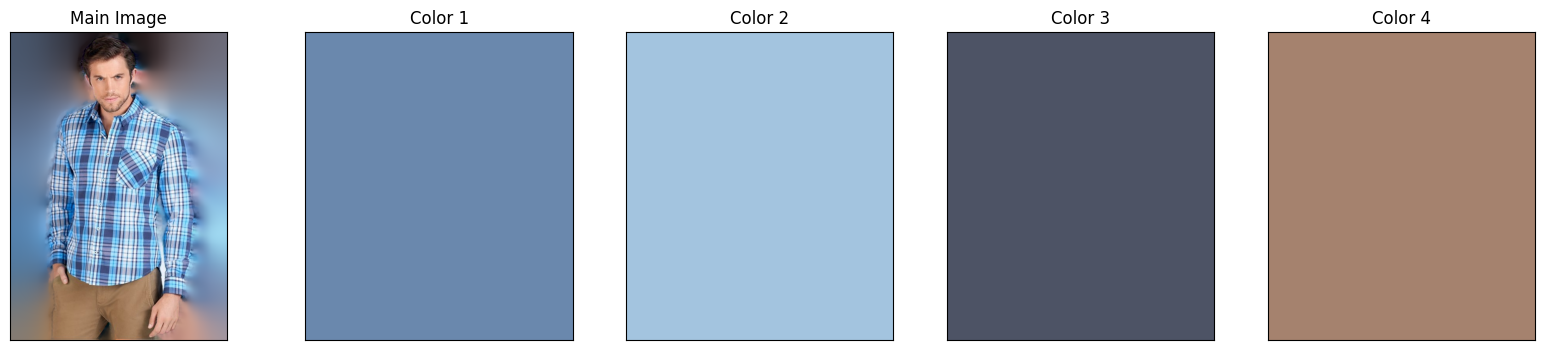

In [115]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Read the main image
#img = cv2.imread("D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg", cv2.IMREAD_UNCHANGED)
img = cv2.imread("test/Chalecos y sacos/CHALECOSMULTICOLOR14718781_masked.jpg")
img = cv2.imread('test/Camisas/CAMISASAZUL14035580_masked.jpg')

#img = cv2.imread("test/Chamarras y abrigos/CHAMARRAABRIGOSGRIS14625310_masked.jpg")

# Extract the dominant colors
dominant_colors = extract_primary_colors(img, 4)

# Create a figure with a size that can fit all the images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Plot the main image
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Main Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot each dominant color
for i, color in enumerate(dominant_colors):
    axs[i+1].set_facecolor(color/255)  # Normalize the RGB values to [0, 1]
    axs[i+1].set_title(f"Color {i+1}")
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])

plt.savefig('images/colour_comparison.png')

plt.show()

# Utilities

## Create test dataset with 30% of the original dataset

In [ ]:
import os
import shutil
import random

# Define source and destination root folders
src_root = 'D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo'
dst_root = 'D:\\tmp\\Andrea\\test\\ZapatoDeportivo'

# Create destination root folder if it doesn't exist
if not os.path.exists(dst_root):
    os.makedirs(dst_root)

# Iterate through subfolders
for subfolder in os.listdir(src_root):
    src_subfolder = os.path.join(src_root, subfolder)
    dst_subfolder = os.path.join(dst_root, subfolder)

    # Create destination subfolder if it doesn't exist
    if not os.path.exists(dst_subfolder):
        os.makedirs(dst_subfolder)

    # Get list of image files in subfolder
    image_files = [f for f in os.listdir(src_subfolder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Calculate number of images to move (30% of total)
    num_images_to_move = int(len(image_files) * 0.3)

    # Randomly select images to move
    images_to_move = random.sample(image_files, num_images_to_move)

    # Move selected images to destination subfolder
    for image in images_to_move:
        src_image = os.path.join(src_subfolder, image)
        dst_image = os.path.join(dst_subfolder, image)
        shutil.move(src_image, dst_image)

    print(f"Moved {num_images_to_move} images to {dst_subfolder}")

## Remove special characters from files

In [29]:
import os
import unicodedata

# Define the directory path
root_dir = 'D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo'

# Function to replace special characters
def replace_special_chars(filename):
    # Normalize filename and encode to ASCII
    filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode()
    
    # Replace remaining special characters
    return ''.join(e for e in filename if e.isalnum() or e in ['_'])

# Walk through directories and rename files
for dir_path, dir_names, file_names in os.walk(root_dir):
    for file_name in file_names:
        new_file_name = replace_special_chars(file_name)
        if file_name != new_file_name:
            os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))
            print(f"Renamed '{file_name}' to '{new_file_name}'")

print("File renaming complete.")

Renamed 'ADIDASARGECYROJO26715430..jpg' to 'ADIDASARGECYROJO26715430jpg'
Renamed 'ADIDASARGECYROJO26715431..jpg' to 'ADIDASARGECYROJO26715431jpg'
Renamed 'ADIDASARGECYROJO26715432..jpg' to 'ADIDASARGECYROJO26715432jpg'
Renamed 'ADIDASARGECYROJO26715433..jpg' to 'ADIDASARGECYROJO26715433jpg'
Renamed 'ADIDASARGECYROJO26715434..jpg' to 'ADIDASARGECYROJO26715434jpg'
Renamed 'ADIDASARGECYROJO26715435..jpg' to 'ADIDASARGECYROJO26715435jpg'
Renamed 'ADIDASARGECYROJO26715436..jpg' to 'ADIDASARGECYROJO26715436jpg'
Renamed 'ADIDASARGECYROJO26715437..jpg' to 'ADIDASARGECYROJO26715437jpg'
Renamed 'ADIDASCOURTSMASHBLANCO27399460..jpg' to 'ADIDASCOURTSMASHBLANCO27399460jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546480..jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546480jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546481..jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546481jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546482..jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546482jpg'
Renamed 'ADIDASDURAMO8TRAINERMAZUL25978290..jpg' to 'ADIDA

## Add extension to files

In [30]:
import os

# Define the directory path
root_dir = 'D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo'

# Walk through directories and rename files
for dir_path, dir_names, file_names in os.walk(root_dir):
    for file_name in file_names:
        # Check if file name ends with 'jpg', 'png', etc.
        if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('jpeg'):
            # Insert '.' before the extension
            new_file_name = file_name[:-3] + '.' + file_name[-3:]
            os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))
            print(f"Renamed '{file_name}' to '{new_file_name}'")

print("File renaming complete.")

Renamed 'ADIDASARGECYROJO26715430jpg' to 'ADIDASARGECYROJO26715430.jpg'
Renamed 'ADIDASARGECYROJO26715431jpg' to 'ADIDASARGECYROJO26715431.jpg'
Renamed 'ADIDASARGECYROJO26715432jpg' to 'ADIDASARGECYROJO26715432.jpg'
Renamed 'ADIDASARGECYROJO26715433jpg' to 'ADIDASARGECYROJO26715433.jpg'
Renamed 'ADIDASARGECYROJO26715434jpg' to 'ADIDASARGECYROJO26715434.jpg'
Renamed 'ADIDASARGECYROJO26715435jpg' to 'ADIDASARGECYROJO26715435.jpg'
Renamed 'ADIDASARGECYROJO26715436jpg' to 'ADIDASARGECYROJO26715436.jpg'
Renamed 'ADIDASARGECYROJO26715437jpg' to 'ADIDASARGECYROJO26715437.jpg'
Renamed 'ADIDASCOURTSMASHBLANCO27399460jpg' to 'ADIDASCOURTSMASHBLANCO27399460.jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546480jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546480.jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546481jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546481.jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546482jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546482.jpg'
Renamed 'ADIDASDURAMO8TRAINERMAZUL25978290jpg' to 'ADIDASDURAMO8TRAINE